# Quiz

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# Perceptron

The perceptron is one of the earliest neural network architectures. It's a single layer network that can do binary classification. The activation function applied on the output node is the **Heaviside step function**. The loss function is hinge loss. This network is in your project 1.

| Approach | Suitable for | Number of layers | Width of input layer | Width of output layer | Activation function on output layer | Loss function |
|----------|--------------|------------------|----------------------|-----------------------|-------------------------------------|---------------|
| Linear regression | regression | 1 | # of features | 1 | identity | MSE |
| Logistic regression | binary/multiclass classification, multi-label classification | 1 | # of features | # of classes | softmax | cross-entropy |
| Perceptron | binary classification | 1 | # of features | 1 | step | hinge |

# Multi layer perceptrons

So far we have fit *linear* functions (in particular, *affine* functions: linear functions with an added bias). What if we want to fit *nonaffine* functions? After all, there are analytical solutions to fitting linear functions in many situations.

In the textbook, they talk a little about why you might want to fit a non-linear function. To me, it's very obvious. Is it obvious to you?

The answer in the neural network context is: **hidden layers**.

Here is the textbook's implementation of MLP from scratch. Let's look.

In [3]:
# activation function
def relu(X):
    # get a tensor of zeros same dimensions as X
    a = torch.zeros_like(X)
    # return the element-wise max of X and the zeros
    return torch.max(X, a)
    
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # the weights and biases for the first layer
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        # the weights and biases for the second layer
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        # do the first matrix multiplication, then apply the nonlinear activation function
        H = relu(torch.matmul(X, self.W1) + self.b1)
        # do the second matrix multiplication
        return torch.matmul(H, self.W2) + self.b2

Note that the MLP here uses the default classification activation function and default classification loss function from pytorch, which are softmax and cross-entropy loss respectively. But that's fine because this is a multi-class classification problem. **The term "MLP" is often used to refer to any feed-forward neural network.**

We train it on the the iris dataset.

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class CsvData(d2l.DataModule):  #@save
    def __init__(self, labelColIndex, path, batch_size=32, shuffle=True, split=0.2):
        super().__init__()
        self.save_hyperparameters()
        # read the data
        df = pd.read_csv(path)
        self.labels = df.iloc[:, labelColIndex].unique()
        colIndices = list(range(df.shape[1]))
        colIndices.pop(labelColIndex)
        features = df.iloc[:, colIndices]
        # one hot encoding of the labels column
        #labels = pd.get_dummies(df.iloc[:, labelColIndex])
        labels = df.iloc[:, labelColIndex]
        labels = labels.apply(lambda x: np.where(self.labels==x)[0][0]).astype(float)
        # split the dataset
        self.train, self.val, self.train_y, self.val_y = train_test_split(features, labels, test_size=split, shuffle=shuffle)
        print("shuffle", shuffle, "batch_size", batch_size, "split", split)
        print(self.get_feature_count(), self.get_train_data_size(), self.get_test_data_size())
         
    def get_feature_count(self):
        return self.train.shape[1]

    def get_label_count(self):
        return len(self.labels)

    def get_train_data_size(self):
        return self.train.shape[0]

    def get_test_data_size(self):
        return self.val.shape[0]
                
    def text_labels(self, indices):
        """Return text labels."""
        return [self.labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        features = self.train if train else self.val
        labels = self.train_y if train else self.val_y
        get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
        tensors = (get_tensor(features), get_tensor(labels).long())
        return self.get_tensorloader(tensors, train)

You can compare this with the performance of the logistic regression classifier from Tuesday. If you are interested, you can take the relu activation function off the hidden layer and prove to yourself that performance degrades (after all, you are trying to estimate twice the weights/biases with the same data).

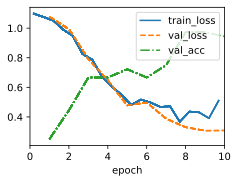

In [9]:
lr = 0.01
epochs = 10
split = 0.2
batch_size = 12
shuffle = True

# You can get the iris data from https://archive-beta.ics.uci.edu/dataset/53/iris
data = CsvData(4,"data/iris.data", batch_size=batch_size, shuffle=shuffle, split=split)
model = MLPScratch(num_inputs=4, num_outputs=3, num_hiddens=256, lr=0.1)

# textbook has this: 
#data = d2l.FashionMNIST(batch_size=256)
#model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)

trainer = d2l.Trainer(max_epochs=epochs)
trainer.fit(model, data)


## More about hidden layers

In a feedforward network, every set of edges corresponds to a function. So far we only know how to fit an affine function:
$\hat{y} = w^T*X + b$.

Let's say we have one hidden layer. That means two affine functions. Does this help?
* $H = W_1*X + b_1$
* $O = W_2*H + b_2 \\ = W_2(W_1*X + b_1) + b_2 \\ = W_2*W_1*X + W_2*b_1 + b_2$ 

Well, this is still an affine function, so just adding layers doesn't help. We need something more.

## Activation functions

An activation function is a nonlinear function that is applied to each hidden unit after the affine transformation has taken place.

Some popular activation functions (https://paperswithcode.com/methods/category/activation-functions):
* ReLU: $ReLU(x) = max(x, 0)$
* sigmoid: $sigmoid(x) = \frac{1}{1+exp(-x)}$
* Tanh: $tanh(x) = \frac{1-exp(-2x)}{1+exp(-2x)}$

**Team activity**: in teams of three, investigate *one* activation function from the following list:
* ReLu (https://icml.cc/Conferences/2010/papers/432.pdf) or leaky ReLu (http://robotics.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)
* sigmoid (https://jontalle.web.engr.illinois.edu/uploads/410-NS.F22/McCulloch-Pitts-1943-neural-networks-ocr.pdf) or softmax (https://papers.nips.cc/paper/1989/file/0336dcbab05b9d5ad24f4333c7658a0e-Paper.pdf)
* tanh (https://ieeexplore.ieee.org/document/227257) or LeCun's tanh (http://yann.lecun.org/exdb/publis/pdf/lecun-98b.pdf)
* Swish (http://proceedings.mlr.press/v48/gulcehre16.pdf) 
* Smish (https://www.mdpi.com/1493326)

1. Use the code in the textbook to plot it / find code to plot it - and send the picture (a screenshot is fine) to the instructor)
2. Look up the original paper (if possible!). Do the authors argue for it on mathematical grounds, empirical grounds, both or neither? How many citations does the original paper have (check e.g. Google Scholar)?
3. Look it up on paperswithcode. How many citations does it have?
4. Is there a pytorch implementation? if so, what and where?

Report back to the class

| Activation function | Picture | Paper | Empirical grounds or theoretical grounds? | Paper citations | Function citations | Pytorch implementation |
|-------------|---------|--------|-------------------------------|--------------|--------------|--------------|
| ReLu | | | | | | |
| Leaky ReLu | | | | | | |
| sigmoid | | | | | | |
| softmax | | | | | | |
| tanh | | | | | | |
| LeCun's tanh | | | | | | |
| Swish | | | | | | |
| Smish | | | | | | |

## Deploy and monitor: The ground is shifting beneath our feet

Let's say you train a model on irises from 1998. However, now it's 2023 and:
* natural selection may have led to changes in iris sizes
* human selection has led to changes in iris sizes

This is **covariate shift**.

Or some biologist may have come along and done genetic testing on our irises, and discovered that some of them were assigned to the wrong species.

This is **label shift**.

Or, based on the genetic testing, the pesky biologist may have discovered that there's a fourth species of iris in our data - a new species.

This is **concept shift**.

The textbook covers some of the theory. Here's some practice:
1. When you deploy your model, monitor its performance over time. This means continuing to label some data periodically, and the comparing your newly labeled data with your previously labeled data. You can discover all three types of drift in this way.
2. If there has been shift, your model may have sufficient generalization to accommodate the shift, or it may not. Evaluate your model on your newly labeled data.
3. If your model's performance has gotten worse, you may need to retrain your model. Many production models are retrained nightly (recommender systems) to quarterly or yearly (image classification, object detection, NLP).